In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import random

# Using CIFAR-10

In [2]:
transform_train = transforms.Compose([
    transforms.Resize(224),  # ResNet input size
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

# Load full training dataset
full_train_dataset = datasets.CIFAR10(root='./data/', train=True, download=True, transform=transform_train)
full_test_dataset = datasets.CIFAR10(root='./data/', train=False, download=True, transform=transform_train)

# Create a subset with 10% of the training data
subset_size = int(0.1 * len(full_train_dataset))
indices = random.sample(range(len(full_train_dataset)), subset_size)
train_subset = Subset(full_train_dataset, indices)

train_loader = DataLoader(
    train_subset,
    batch_size=64, shuffle=True
)

# Create a subset with 20% of the test data
subset_size = int(0.2 * len(full_test_dataset))
indices = random.sample(range(len(full_test_dataset)), subset_size)
test_subset = Subset(full_test_dataset, indices)

test_loader = DataLoader(
    test_subset,
    batch_size=256, shuffle=False
)

/Users/adan.mora/Desktop/code/university/computer-vision-course/venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [3]:
len(test_loader.dataset), len(train_loader.dataset)

(2000, 5000)

# Teacher Model - Resnet 18

In [ ]:
# Teacher: ResNet18
teacher = models.resnet18(pretrained=True)

num_ftrs = teacher.fc.in_features
teacher.fc = torch.nn.Linear(num_ftrs, 10)  # For CIFAR-10

optimizer_t = optim.Adam(teacher.parameters(), lr=0.001)
for epoch in range(1):  # 1 epoch just to have a semi-trained teacher
    teacher.train()
    for imgs, labels in train_loader:
        optimizer_t.zero_grad()
        loss = F.cross_entropy(teacher(imgs), labels)
        loss.backward()
        optimizer_t.step()

# Teacher accuracy
def accuracy(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            preds = model(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

print("Teacher accuracy:", accuracy(teacher))

In [5]:
# Save Teacher state
torch.save(teacher.state_dict(), f"./data/resnet18_teacher_state_one_epoch.pth")

# Shared in Drive folder: https://drive.google.com/drive/folders/1ZbYJft8q1wVr74rCDuIUuBA_oB-QUBvo?usp=drive_link

In [6]:
# Load Teacher state

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)

model.load_state_dict(torch.load("./data/resnet18_teacher_state_one_epoch.pth", weights_only=True, map_location=torch.device('cpu')))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Tiny Student model

In [10]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(200704, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# Distillation Loss

In [8]:
def distillation_loss(student_logits, teacher_logits, labels, T, alpha):
    hard_loss = F.cross_entropy(student_logits, labels)
    soft_loss = F.kl_div(
        F.softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T * T)                 # We multiply the KL loss by T^2 to keep gradient magnitudes balanced after scaling.
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Training Student using the Distillation process

In [11]:
student = TinyCNN()
optimizer_s = optim.Adam(student.parameters(), lr=0.001)
T = 4.0
alpha = 0.7
epochs = 10

student_acc_list = []
teacher_acc_list = []
kl_distance_list = []

for epoch in range(epochs):
    student.train()
    for imgs, labels in train_loader:
        with torch.no_grad():
            teacher_logits = teacher(imgs)

        optimizer_s.zero_grad()
        student_logits = student(imgs)
        loss = distillation_loss(student_logits, teacher_logits, labels, T, alpha)

        loss.backward()
        optimizer_s.step()

    # Track metrics
    student_acc = accuracy(student)
    teacher_acc = accuracy(teacher)
    student_acc_list.append(student_acc)
    teacher_acc_list.append(teacher_acc)

    # KL divergence measure
    kl_total = 0
    with torch.no_grad():
        for imgs, _ in test_loader:
            st_logits = student(imgs)
            tc_logits = teacher(imgs)
            kl_total += F.kl_div(
                F.log_softmax(st_logits / T, dim=1),
                F.softmax(tc_logits / T, dim=1),
                reduction='batchmean'
            ).item()
    kl_distance_list.append(kl_total / len(test_loader))

    print(f"Epoch {epoch+1}: Student Acc={student_acc:.3f}, KL Dist={kl_distance_list[-1]:.4f}")

Epoch 1: Student Acc=0.259, KL Dist=0.3088
Epoch 2: Student Acc=0.280, KL Dist=0.5193
Epoch 3: Student Acc=0.333, KL Dist=0.3845
Epoch 4: Student Acc=0.365, KL Dist=0.4809
Epoch 5: Student Acc=0.410, KL Dist=0.5326
Epoch 6: Student Acc=0.433, KL Dist=0.6019
Epoch 7: Student Acc=0.446, KL Dist=0.8449
Epoch 8: Student Acc=0.422, KL Dist=0.9310
Epoch 9: Student Acc=0.433, KL Dist=1.0630
Epoch 10: Student Acc=0.458, KL Dist=1.3718


# Evaluation results

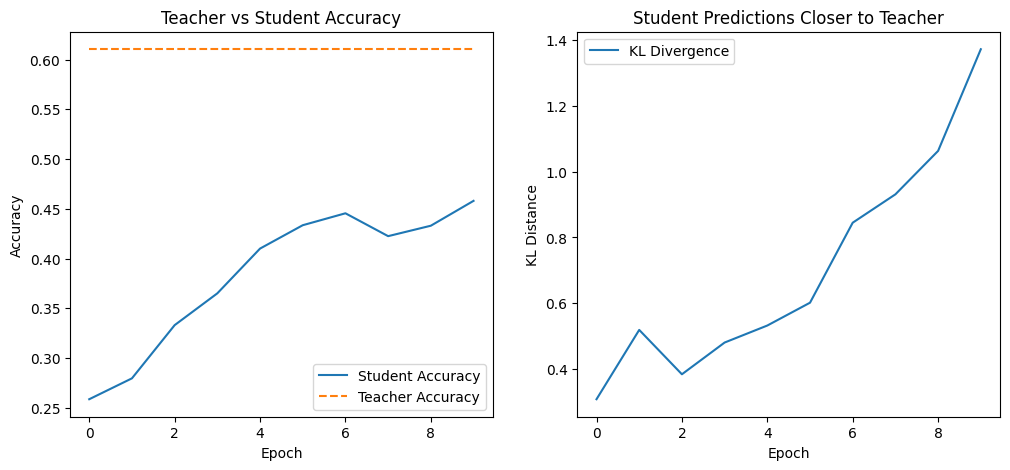

In [12]:


# ----- 6. Plot -----
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(student_acc_list, label='Student Accuracy')
plt.plot(teacher_acc_list, label='Teacher Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Teacher vs Student Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(kl_distance_list, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('KL Distance')
plt.title('Student Predictions Closer to Teacher')
plt.legend()

plt.show()
